# **Transformer From Scratch**
*By Cristian Leo*

[Read the article](https://medium.com/@cristianleo120/the-math-behind-transformers-6d7710682a1f)

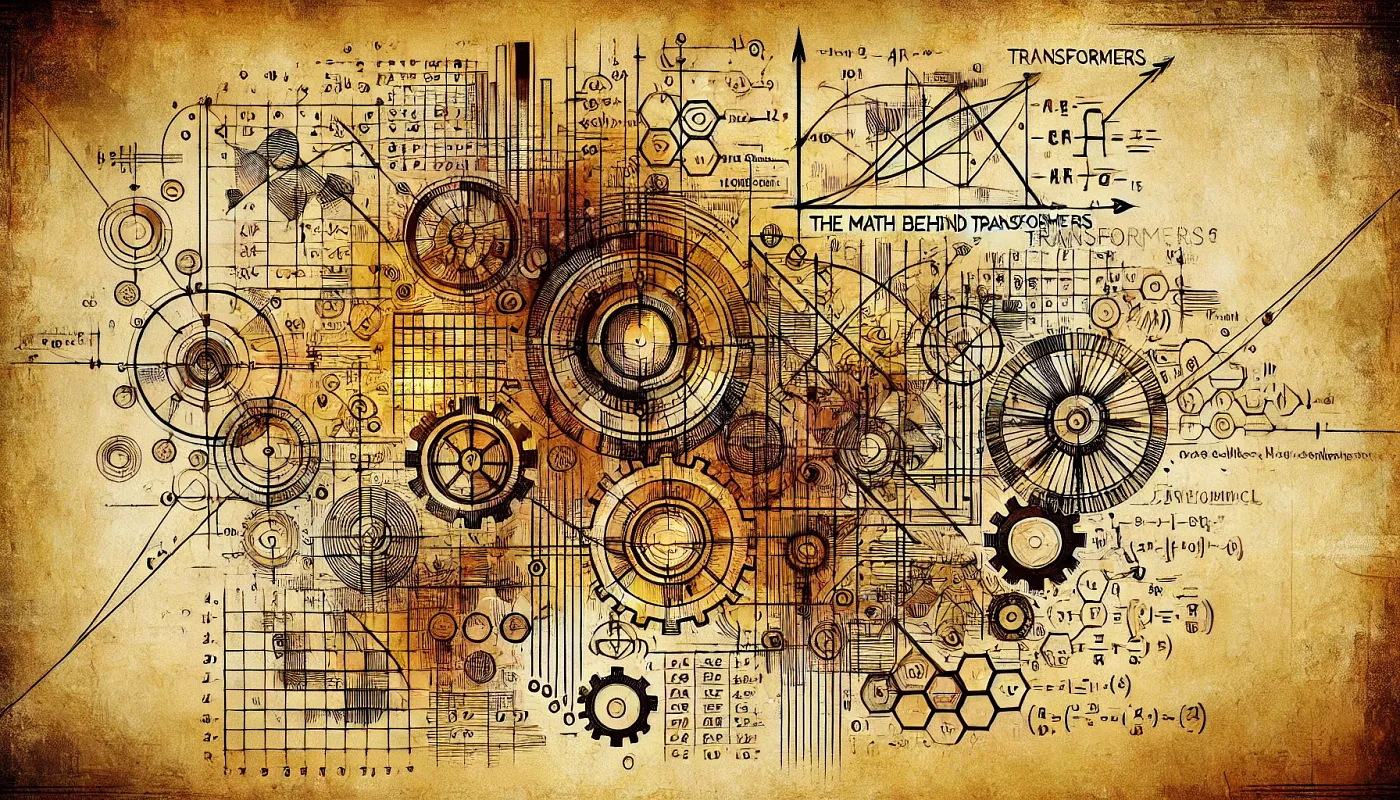

## **Required Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **Attention Mechanism**

In [2]:
class MultiHeadAttention:
    """
    Multi-head attention mechanism.

    Parameters:
    ----------
    num_hiddens : int
        Number of hidden units.
    num_heads : int
        Number of attention heads.
    dropout : float, optional
        Dropout rate (default is 0.0).
    bias : bool, optional
        Whether to include bias parameters (default is False).
    """
    def __init__(self, num_hiddens: int, num_heads: int, dropout: float = 0.0, bias: bool = False):
        self.num_heads = num_heads
        self.num_hiddens = num_hiddens
        self.d_k = self.d_v = num_hiddens // num_heads
        
        self.W_q = np.random.rand(num_hiddens, num_hiddens)
        self.W_k = np.random.rand(num_hiddens, num_hiddens)
        self.W_v = np.random.rand(num_hiddens, num_hiddens)
        self.W_o = np.random.rand(num_hiddens, num_hiddens)
        
        if bias:
            self.b_q = np.random.rand(num_hiddens)
            self.b_k = np.random.rand(num_hiddens)
            self.b_v = np.random.rand(num_hiddens)
            self.b_o = np.random.rand(num_hiddens)
        else:
            self.b_q = self.b_k = self.b_v = self.b_o = np.zeros(num_hiddens)

    def transpose_qkv(self, X: np.ndarray) -> np.ndarray:
        """
        Transpose X to (batch_size, num_heads, seq_len, d_k).

        Parameters:
        ----------
        X : np.ndarray
            Input tensor of shape (batch_size, seq_len, num_hiddens).
        
        Returns:
        -------
        np.ndarray
            Transposed tensor of shape (batch_size * num_heads, seq_len, d_k).
        """
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
        X = X.transpose(0, 2, 1, 3)
        return X.reshape(-1, X.shape[2], X.shape[3])
    
    def transpose_output(self, X: np.ndarray) -> np.ndarray:
        """
        Transpose X to (batch_size, seq_len, num_heads * d_v).
        
        Parameters:
        ----------
        X : np.ndarray
            Input tensor of shape (batch_size * num_heads, seq_len, d_v).
        
        Returns:
        -------
        np.ndarray
            Transposed tensor of shape (batch_size, seq_len, num_heads * d_v).
        """
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        X = X.transpose(0, 2, 1, 3)
        return X.reshape(X.shape[0], X.shape[1], -1)
    
    def scaled_dot_product_attention(self, Q: np.ndarray, K: np.ndarray, V: np.ndarray, valid_lens: np.ndarray = None) -> np.ndarray:
        """
        Compute scaled dot-product attention.

        Parameters:
        ----------
        Q : np.ndarray
            Query tensor of shape (batch_size * num_heads, seq_len, d_k).
        K : np.ndarray
            Key tensor of shape (batch_size * num_heads, seq_len, d_k).
        V : np.ndarray
            Value tensor of shape (batch_size * num_heads, seq_len, d_v).
        valid_lens : np.ndarray, optional
            Valid lengths for the sequences (default is None).
        
        Returns:
        -------
        np.ndarray
            Output tensor of shape (batch_size * num_heads, seq_len, d_v).
        """
        d_k = Q.shape[-1]
        scores = np.matmul(Q, K.transpose(0, 2, 1)) / np.sqrt(d_k)
        if valid_lens is not None:
            mask = np.arange(scores.shape[-1]) < valid_lens[:, None]
            scores = np.where(mask[:, None, :], scores, -np.inf)
        attention_weights = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
        attention_weights /= attention_weights.sum(axis=-1, keepdims=True)
        return np.matmul(attention_weights, V)
    
    def forward(self, queries: np.ndarray, keys: np.ndarray, values: np.ndarray, valid_lens: np.ndarray = None) -> np.ndarray:
        """
        Forward pass through the multi-head attention mechanism.

        Parameters:
        ----------
        queries : np.ndarray
            Query tensor of shape (batch_size, seq_len, num_hiddens).
        keys : np.ndarray
            Key tensor of shape (batch_size, seq_len, num_hiddens).
        values : np.ndarray
            Value tensor of shape (batch_size, seq_len, num_hiddens).
        valid_lens : np.ndarray, optional
            Valid lengths for the sequences (default is None).
        
        Returns:
        -------
        np.ndarray
            Output tensor of shape (batch_size, seq_len, num_hiddens).
        """
        queries = self.transpose_qkv(np.dot(queries, self.W_q) + self.b_q)
        keys = self.transpose_qkv(np.dot(keys, self.W_k) + self.b_k)
        values = self.transpose_qkv(np.dot(values, self.W_v) + self.b_v)
        
        if valid_lens is not None:
            valid_lens = np.repeat(valid_lens, self.num_heads, axis=0)
        
        output = self.scaled_dot_product_attention(queries, keys, values, valid_lens)
        output_concat = self.transpose_output(output)
        return np.dot(output_concat, self.W_o) + self.b_o

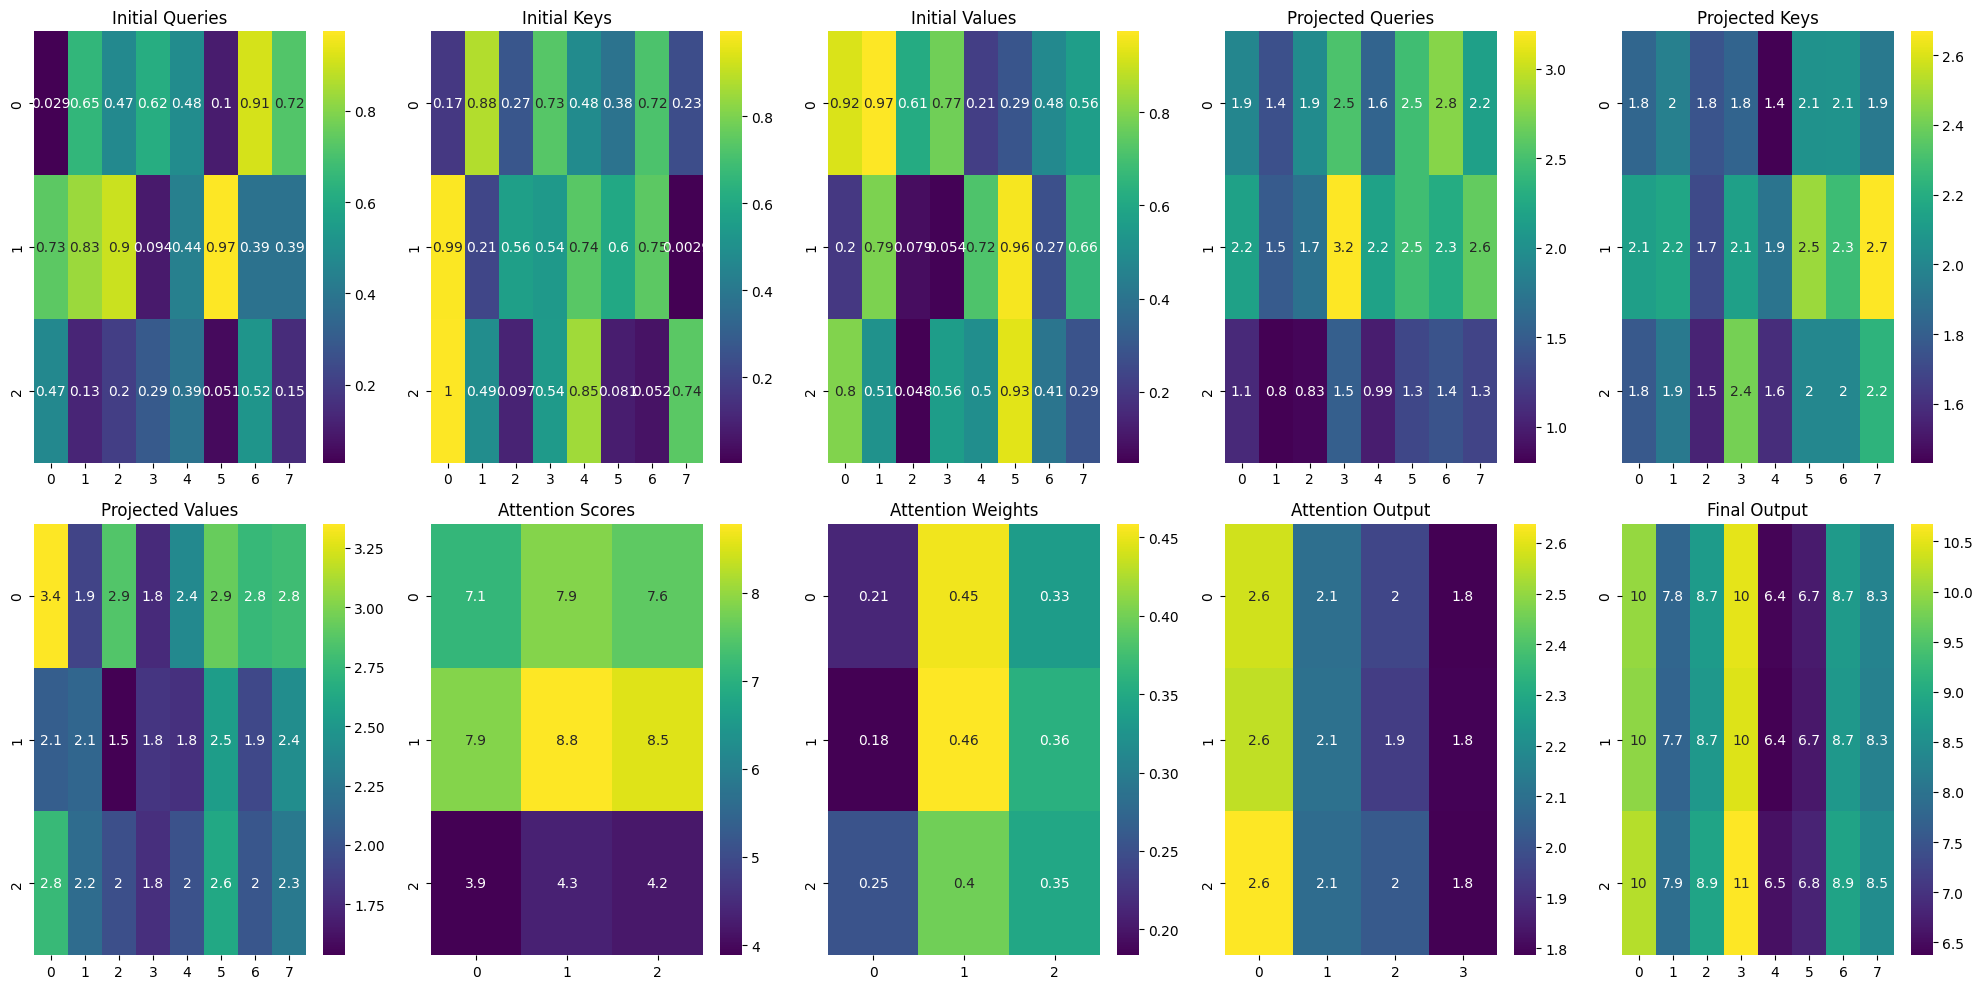

In [3]:
# Initialize multi-head attention
num_hiddens = 8
num_heads = 2
attention = MultiHeadAttention(num_hiddens, num_heads)

# Dummy input data
batch_size = 2
seq_len = 3
input_dim = num_hiddens

queries = np.random.rand(batch_size, seq_len, input_dim)
keys = np.random.rand(batch_size, seq_len, input_dim)
values = np.random.rand(batch_size, seq_len, input_dim)

# Project Queries, Keys, and Values
projected_queries = np.dot(queries, attention.W_q) + attention.b_q
projected_keys = np.dot(keys, attention.W_k) + attention.b_k
projected_values = np.dot(values, attention.W_v) + attention.b_v

# Transpose for Multi-Head Attention
transposed_queries = attention.transpose_qkv(projected_queries)
transposed_keys = attention.transpose_qkv(projected_keys)
transposed_values = attention.transpose_qkv(projected_values)

# Scaled Dot-Product Attention
valid_lens = None
attention_scores = np.matmul(transposed_queries, transposed_keys.transpose(0, 2, 1)) / np.sqrt(attention.d_k)
attention_weights = np.exp(attention_scores - np.max(attention_scores, axis=-1, keepdims=True))
attention_weights /= attention_weights.sum(axis=-1, keepdims=True)
attention_output = np.matmul(attention_weights, transposed_values)

# Transpose Output
output_concat = attention.transpose_output(attention_output)
final_output = np.dot(output_concat, attention.W_o) + attention.b_o

def plot_heatmaps(matrices, titles, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
    for i, ax in enumerate(axes.flat):
        sns.heatmap(matrices[i], annot=True, cmap='viridis', cbar=True, ax=ax)
        ax.set_title(titles[i])
    plt.tight_layout()
    plt.show()

# Plot matrices
matrices = [
    queries[0], keys[0], values[0],
    projected_queries[0], projected_keys[0], projected_values[0],
    attention_scores[0], attention_weights[0], attention_output[0],
    final_output[0]
]

titles = [
    "Initial Queries", "Initial Keys", "Initial Values",
    "Projected Queries", "Projected Keys", "Projected Values",
    "Attention Scores", "Attention Weights", "Attention Output",
    "Final Output"
]

plot_heatmaps(matrices, titles, 2, 5)

## **Positional Encoding**

In [4]:
def positional_encoding(seq_len: int, d_model: int) -> np.ndarray:
    """
    Compute positional encoding.

    Parameters:
    ----------
    seq_len : int
        Sequence length.
    d_model : int
        Number of hidden units.
    
    Returns:
    -------
    np.ndarray
        Positional encoding matrix of shape (seq_len, d_model).
    """
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    pos_encoding = pos * angle_rates
    
    pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])
    
    return pos_encoding

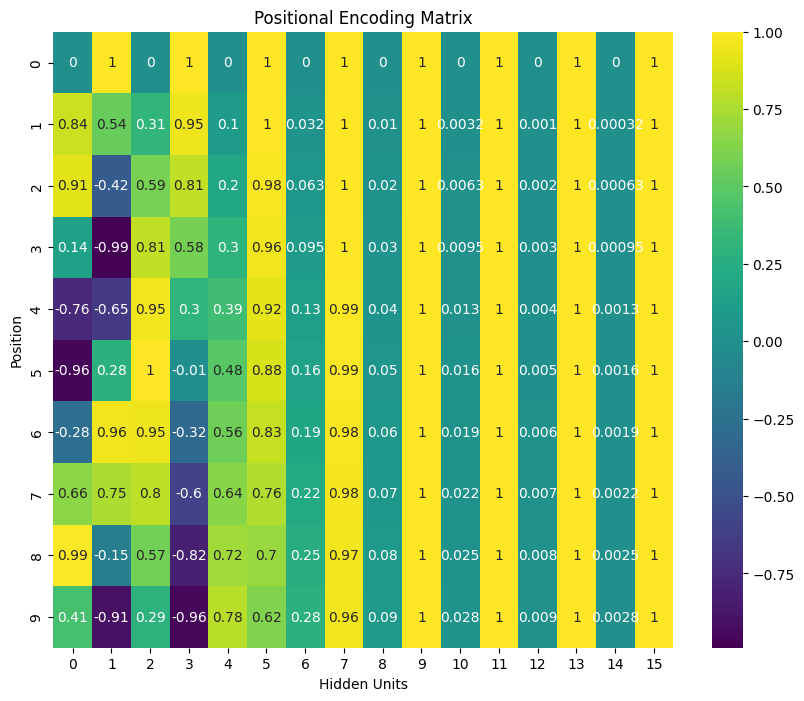

In [5]:
# Example
seq_len = 10
d_model = 16

# Compute positional encoding
pos_encoding = positional_encoding(seq_len, d_model)

# Plot the positional encoding matrix
def plot_positional_encoding(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, cmap='viridis', cbar=True)
    plt.title(title)
    plt.xlabel('Hidden Units')
    plt.ylabel('Position')
    plt.show()

plot_positional_encoding(pos_encoding, "Positional Encoding Matrix")


## **Feedforward Network**

In [6]:
class FeedForward:
    """
    Feed-Forward Neural Network with ReLU activation.

    Parameters:
    ----------
    d_model : int
        Dimension of the model.
    d_ff : int
        Dimension of the feed-forward layer.
    """
    def __init__(self, d_model: int, d_ff: int):
        self.W1 = np.random.randn(d_model, d_ff) * np.sqrt(2.0 / (d_model + d_ff))
        self.b1 = np.zeros(d_ff)
        self.W2 = np.random.randn(d_ff, d_model) * np.sqrt(2.0 / (d_ff + d_model))
        self.b2 = np.zeros(d_model)

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """
        Forward pass.

        Parameters:
        ----------
        x : np.ndarray
            Input tensor of shape (batch_size, seq_len, d_model).
        
        Returns:
        -------
        np.ndarray
            Output tensor of shape (batch_size, seq_len, d_model).
        """
        return self.forward(x)

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Compute the forward pass of the feed-forward network.

        Parameters:
        ----------
        x : np.ndarray
            Input tensor of shape (batch_size, seq_len, d_model).
        
        Returns:
        -------
        np.ndarray
            Output tensor of shape (batch_size, seq_len, d_model).
        """
        return np.dot(np.maximum(0, np.dot(x, self.W1) + self.b1), self.W2) + self.b2

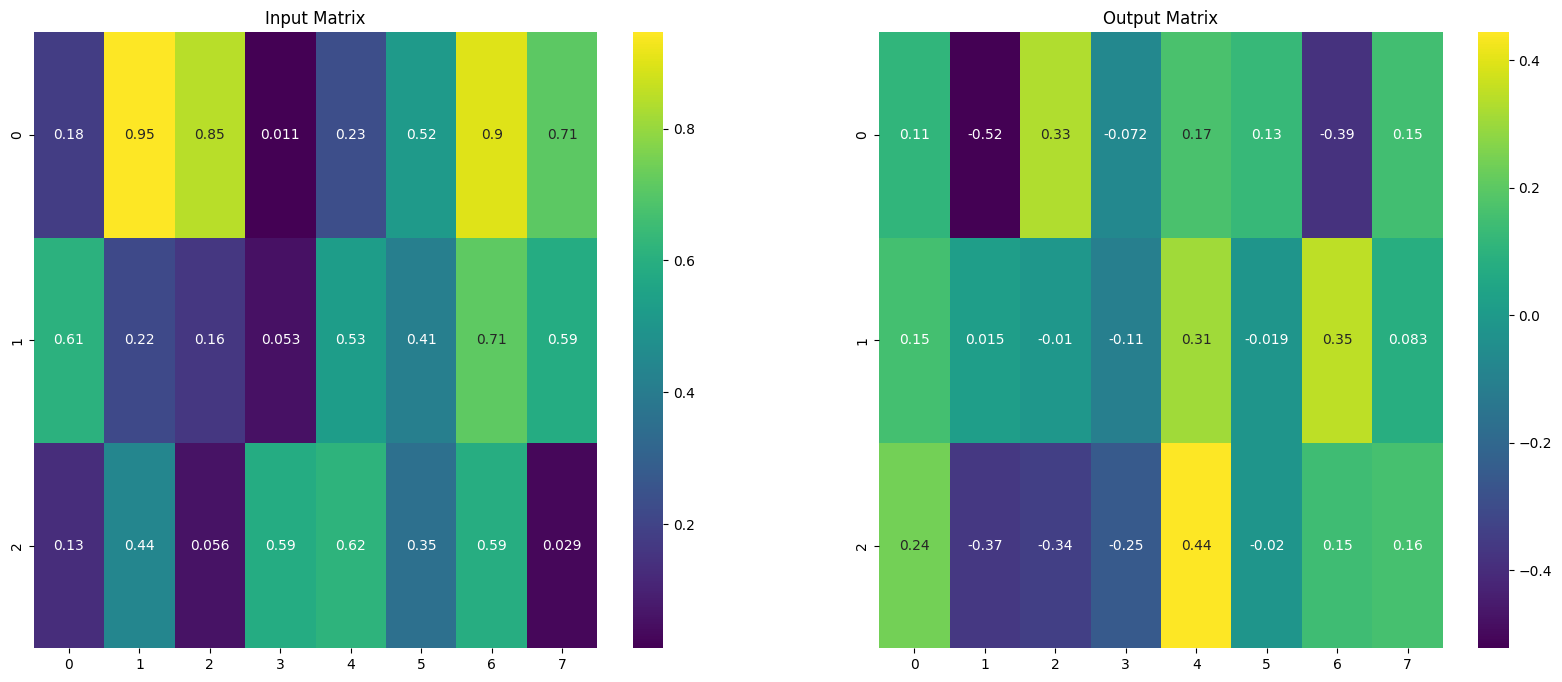

In [7]:
# Example
d_model = 8
d_ff = 16
batch_size = 2
seq_len = 3

# Initialize feed-forward network
ffn = FeedForward(d_model, d_ff)

# Dummy input data
x = np.random.rand(batch_size, seq_len, d_model)

# Forward pass
output = ffn(x)

# Plot the input and output matrices
def plot_matrices(input_matrix, output_matrix, input_title, output_title):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    sns.heatmap(input_matrix, annot=True, cmap='viridis', cbar=True, ax=axes[0])
    axes[0].set_title(input_title)
    sns.heatmap(output_matrix, annot=True, cmap='viridis', cbar=True, ax=axes[1])
    axes[1].set_title(output_title)
    plt.show()

plot_matrices(x[0], output[0], "Input Matrix", "Output Matrix")

## **Encoder Layer**

In [8]:
class EncoderLayer:
    """
    Encoder layer of the Transformer model.

    Parameters:
    ----------
    d_model : int
        Dimension of the model.
    num_heads : int
        Number of attention heads.
    d_ff : int
        Dimension of the feed-forward layer.
    dropout : float, optional
        Dropout rate (default is 0.0).
    bias : bool, optional
        Whether to include bias parameters (default is False).
    """
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.0, bias: bool = False):
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads, dropout, bias)
        self.feed_forward = FeedForward(d_model, d_ff)

    def __call__(self, x: np.ndarray, mask: np.ndarray = None) -> np.ndarray:
        """
        Forward pass through the encoder layer.

        Parameters:
        ----------
        x : np.ndarray
            Input tensor of shape (batch_size, seq_len, d_model).
        mask : np.ndarray, optional
            Mask tensor of shape (batch_size, seq_len) (default is None).
        
        Returns:
        -------
        np.ndarray
            Output tensor of shape (batch_size, seq_len, d_model).
        """
        return self.forward(x, mask)

    def forward(self, x: np.ndarray, mask: np.ndarray = None) -> np.ndarray:
        """
        Compute the forward pass of the encoder layer.

        Parameters:
        ----------
        x : np.ndarray
            Input tensor of shape (batch_size, seq_len, d_model).
        mask : np.ndarray, optional
            Mask tensor of shape (batch_size, seq_len) (default is None).
        
        Returns:
        -------
        np.ndarray
            Output tensor of shape (batch_size, seq_len, d_model).
        """
        attn_output = self.multi_head_attention.forward(x, x, x, mask)
        output = self.feed_forward(attn_output)
        return output

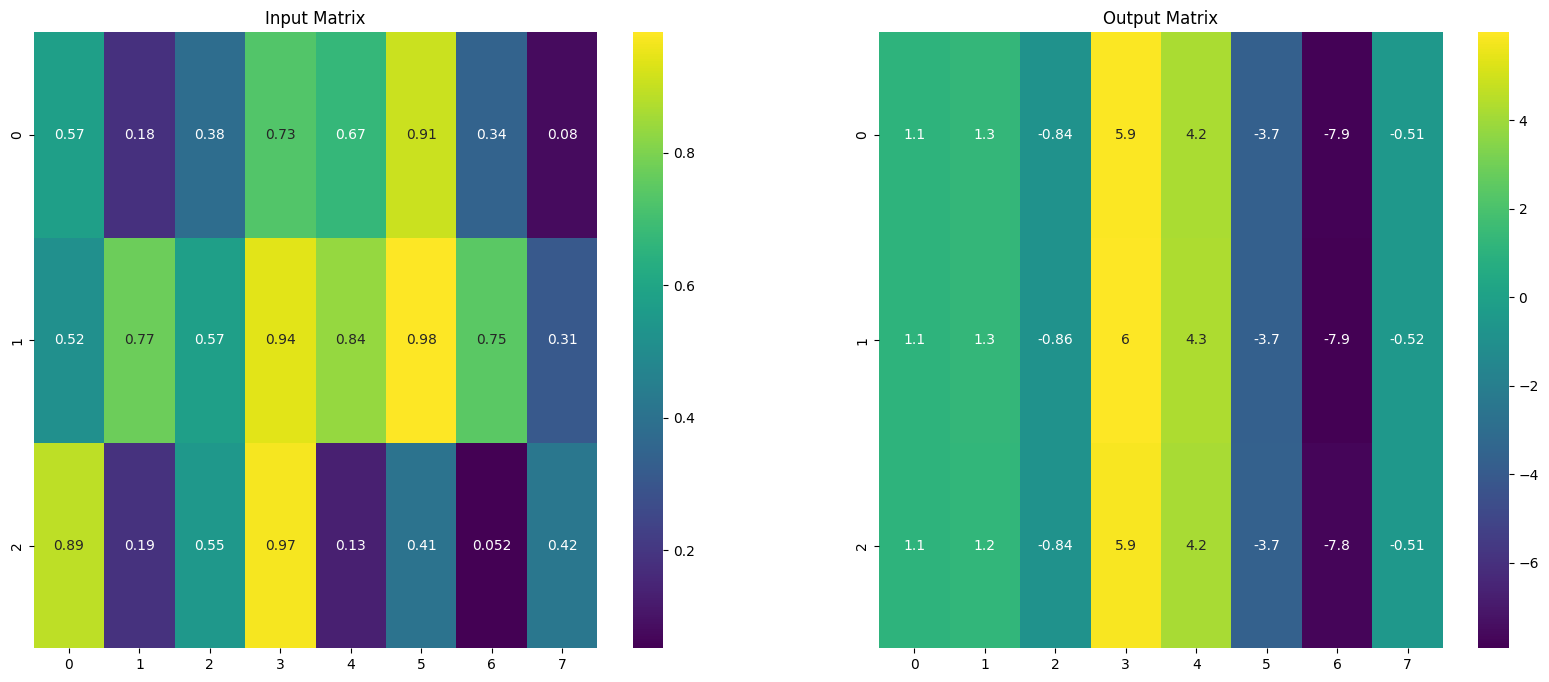

In [9]:
# Example
d_model = 8
num_heads = 2
d_ff = 16
batch_size = 2
seq_len = 3

# Initialize encoder layer
encoder_layer = EncoderLayer(d_model, num_heads, d_ff)

# Dummy input data
x = np.random.rand(batch_size, seq_len, d_model)

# Forward pass
output = encoder_layer(x)

# Plot the input and output matrices
def plot_matrices(input_matrix, output_matrix, input_title, output_title):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    sns.heatmap(input_matrix, annot=True, cmap='viridis', cbar=True, ax=axes[0])
    axes[0].set_title(input_title)
    sns.heatmap(output_matrix, annot=True, cmap='viridis', cbar=True, ax=axes[1])
    axes[1].set_title(output_title)
    plt.show()

plot_matrices(x[0], output[0], "Input Matrix", "Output Matrix")

## **Decoder Layer**

In [10]:
class DecoderLayer:
    """
    Decoder layer of the Transformer model.

    Parameters:
    ----------
    d_model : int
        Dimension of the model.
    num_heads : int
        Number of attention heads.
    d_ff : int
        Dimension of the feed-forward layer.
    dropout : float, optional
        Dropout rate (default is 0.0).
    bias : bool, optional
        Whether to include bias parameters (default is False).
    """
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.0, bias: bool = False):
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        
        self.multi_head_attention_1 = MultiHeadAttention(d_model, num_heads, dropout, bias)
        self.multi_head_attention_2 = MultiHeadAttention(d_model, num_heads, dropout, bias)
        self.feed_forward = FeedForward(d_model, d_ff)

    def __call__(self, x: np.ndarray, enc_output: np.ndarray, mask: np.ndarray = None) -> np.ndarray:
        """
        Forward pass through the decoder layer.
        
        Parameters:
        ----------
        x : np.ndarray
            Input tensor of shape (batch_size, seq_len, d_model).
        enc_output : np.ndarray
            Encoder output tensor of shape (batch_size, seq_len, d_model).
        mask : np.ndarray, optional
            Mask tensor of shape (batch_size, seq_len) (default is None).
        
        Returns:
        -------
        np.ndarray
            Output tensor of shape (batch_size, seq_len, d_model).
        """
        return self.forward(x, enc_output, mask)

    def forward(self, x: np.ndarray, enc_output: np.ndarray, mask: np.ndarray = None) -> np.ndarray:
        """
        Compute the forward pass of the decoder layer.

        Parameters:
        ----------
        x : np.ndarray
            Input tensor of shape (batch_size, seq_len, d_model).
        enc_output : np.ndarray
            Encoder output tensor of shape (batch_size, seq_len, d_model).
        mask : np.ndarray, optional
            Mask tensor of shape (batch_size, seq_len) (default is None).
        
        Returns:
        -------
        np.ndarray
            Output tensor of shape (batch_size, seq_len, d_model).
        """
        attn_output1 = self.multi_head_attention_1.forward(x, x, x, mask)
        attn_output2 = self.multi_head_attention_2.forward(attn_output1, enc_output, enc_output, mask)
        output = self.feed_forward(attn_output2)
        return output

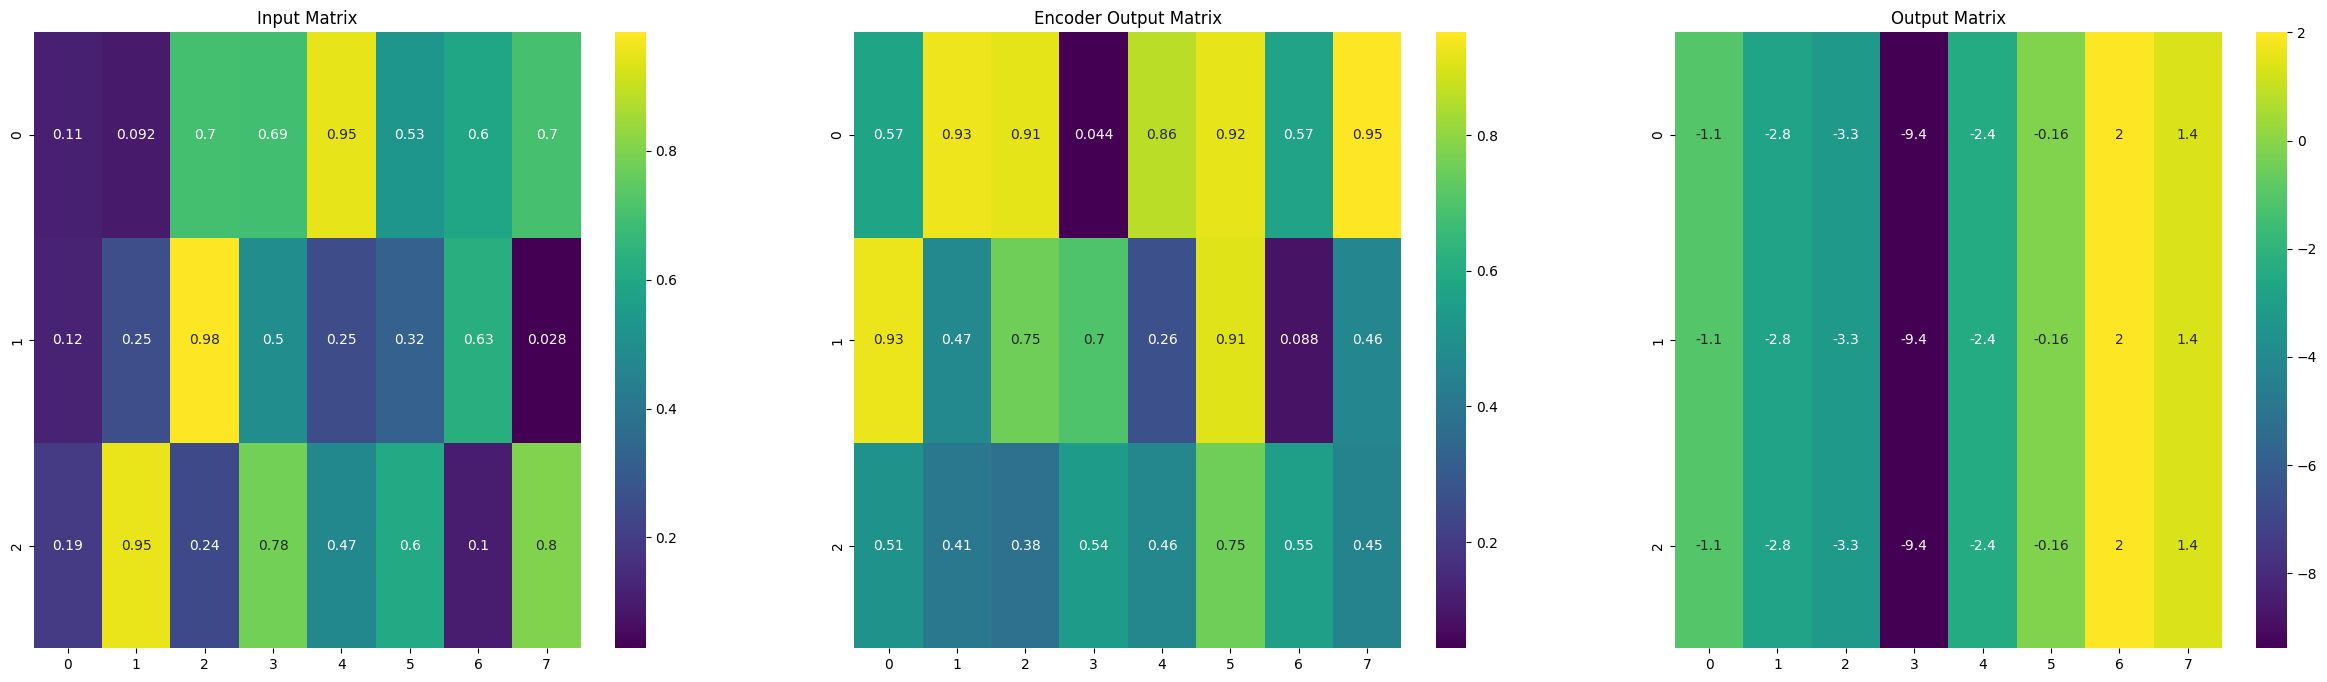

In [11]:
# Example
d_model = 8
num_heads = 2
d_ff = 16
batch_size = 2
seq_len = 3

# Initialize decoder layer
decoder_layer = DecoderLayer(d_model, num_heads, d_ff)

# Dummy input data
x = np.random.rand(batch_size, seq_len, d_model)
enc_output = np.random.rand(batch_size, seq_len, d_model)

# Forward pass
output = decoder_layer(x, enc_output)

# Plot the input and output matrices
def plot_matrices(input_matrix, enc_output_matrix, output_matrix, input_title, enc_output_title, output_title):
    fig, axes = plt.subplots(1, 3, figsize=(30, 8))
    sns.heatmap(input_matrix, annot=True, cmap='viridis', cbar=True, ax=axes[0])
    axes[0].set_title(input_title)
    sns.heatmap(enc_output_matrix, annot=True, cmap='viridis', cbar=True, ax=axes[1])
    axes[1].set_title(enc_output_title)
    sns.heatmap(output_matrix, annot=True, cmap='viridis', cbar=True, ax=axes[2])
    axes[2].set_title(output_title)
    plt.show()

plot_matrices(x[0], enc_output[0], output[0], "Input Matrix", "Encoder Output Matrix", "Output Matrix")

## **Transformer Model**

In [12]:
class Transformer:
    """
    Transformer model.

    Parameters:
    ----------
    d_model : int
        Dimension of the model.
    num_heads : int
        Number of attention heads.
    d_ff : int
        Dimension of the feed-forward layer.
    num_layers : int
        Number of encoder and decoder layers.
    input_vocab_size : int
        Size of the input vocabulary.
    target_vocab_size : int
        Size of the target vocabulary.
    max_seq_len : int
        Maximum sequence length.
    """
    def __init__(self, d_model: int, num_heads: int, d_ff: int, num_layers: int, input_vocab_size: int, target_vocab_size: int, max_seq_len: int):
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.num_layers = num_layers
        self.input_vocab_size = input_vocab_size
        self.target_vocab_size = target_vocab_size
        self.max_seq_len = max_seq_len
        
        self.encoder_layers = [EncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)]
        self.decoder_layers = [DecoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)]
        
        self.embedding = np.random.randn(input_vocab_size, d_model) * np.sqrt(2.0 / (input_vocab_size + d_model))
        self.pos_encoding = positional_encoding(max_seq_len, d_model)
        self.output_layer = np.random.randn(d_model, target_vocab_size) * np.sqrt(2.0 / (d_model + target_vocab_size))

    def __call__(self, input_seq: np.ndarray, target_seq: np.ndarray, mask: np.ndarray = None) -> np.ndarray:
        """
        Forward pass through the Transformer model.
        
        Parameters:
        ----------
        input_seq : np.ndarray
            Input tensor of shape (batch_size, seq_len).
        target_seq : np.ndarray
            Target tensor of shape (batch_size, seq_len).
        mask : np.ndarray, optional
            Mask tensor of shape (batch_size, seq_len) (default is None).
        
        Returns:
        -------
        np.ndarray
            Output tensor of shape (batch_size, seq_len, target_vocab_size).
        """
        return self.forward(input_seq, target_seq, mask)

    def forward(self, input_seq: np.ndarray, target_seq: np.ndarray, mask: np.ndarray = None) -> np.ndarray:
        """
        Forward pass through the Transformer model.
        
        Parameters:
        ----------
        input_seq : np.ndarray
            Input tensor of shape (batch_size, seq_len).
        target_seq : np.ndarray
            Target tensor of shape (batch_size, seq_len).
        mask : np.ndarray, optional
            Mask tensor of shape (batch_size, seq_len) (default is None).
        
        Returns:
        -------
        np.ndarray
            Output tensor of shape (batch_size, seq_len, target_vocab_size).
        """
        enc_output = self.encode(input_seq, mask)
        dec_output = self.decode(target_seq, enc_output, mask)
        output = np.dot(dec_output, self.output_layer)
        return output

    def encode(self, input_seq: np.ndarray, mask: np.ndarray = None) -> np.ndarray:
        """
        Encode the input sequence.
        
        Parameters:
        ----------
        input_seq : np.ndarray
            Input tensor of shape (batch_size, seq_len).
        mask : np.ndarray, optional
            Mask tensor of shape (batch_size, seq_len) (default is None).
        
        Returns:
        -------
        np.ndarray
            Output tensor of shape (batch_size, seq_len, d_model).
        """
        seq_len = input_seq.shape[1]
        x = self.embedding[input_seq] + self.pos_encoding[:seq_len, :]
        
        for layer in self.encoder_layers:
            x = layer(x, mask)
        
        return x

    def decode(self, target_seq: np.ndarray, enc_output: np.ndarray, mask: np.ndarray = None) -> np.ndarray:
        """
        Decode the target sequence.

        Parameters:
        ----------
        target_seq : np.ndarray
            Target tensor of shape (batch_size, seq_len).
        enc_output : np.ndarray
            Encoder output tensor of shape (batch_size, seq_len, d_model).
        mask : np.ndarray, optional
            Mask tensor of shape (batch_size, seq_len) (default is None).
        
        Returns:
        -------
        np.ndarray
            Output tensor of shape (batch_size, seq_len, d_model).
        """
        seq_len = target_seq.shape[1]
        x = self.embedding[target_seq] + self.pos_encoding[:seq_len, :]
        
        for layer in self.decoder_layers:
            x = layer(x, enc_output, mask)
        
        return x

In [13]:
# Example
d_model = 512
num_heads = 8
d_ff = 2048
num_layers = 6
input_vocab_size = 10000
target_vocab_size = 10000
max_seq_len = 100

# Create a transformer model
transformer = Transformer(d_model, num_heads, d_ff, num_layers, input_vocab_size, target_vocab_size, max_seq_len)

# Dummy input and target sequences
input_seq = np.random.randint(0, input_vocab_size, (32, 50))
target_seq = np.random.randint(0, target_vocab_size, (32, 50))

# Forward pass through the model
output = transformer(input_seq, target_seq)
print(output.shape)  # Should be (batch_size, target_seq_len, target_vocab_size)

(32, 50, 10000)
